In [7]:
# loading latent data
import numpy as np
import matplotlib.pyplot as plt

latent_data = np.load('Latent data/latentdata.npy')
labels = np.load('Latent data/simlabels.npy')

In [87]:
labels.shape

(63110,)

In [91]:
# count the number of each label
unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts))

{0.0: 7445,
 1.0: 19354,
 2.0: 12220,
 3.0: 1900,
 4.0: 1982,
 5.0: 12821,
 6.0: 7361,
 7.0: 14,
 8.0: 8,
 9.0: 5}

In [8]:
labels_vectors = np.zeros((len(labels), 10))
for i in range(len(labels)):
    labels_vectors[i][int(labels[i])] = 1

In [9]:
from sklearn.model_selection import train_test_split
import torch

X_train, X_test, y_train, y_test = train_test_split(latent_data, labels_vectors, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32) 
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

In [10]:
device = torch.device("mps")

In [11]:
# Building an MLP model
import torch.nn as nn
import torch.optim as optim

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(16, 20)
        self.fc2 = nn.Linear(20, 50)
        self.fc3 = nn.Linear(50, 10)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [8]:
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=200, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=200, shuffle=False)

In [9]:
# Training loop
num_epochs = 300
losses = [] # To store training losses
val_losses = []  # To store validation losses

for epoch in range(num_epochs):
    loss = 0.0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        curr_loss = criterion(outputs, targets)
        curr_loss.backward()
        optimizer.step()
        loss += curr_loss.item()

    loss /= len(dataloader)
    losses.append(loss)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_inputs, val_targets in val_dataloader:
            val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_targets).item()
    
    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)


    if (epoch + 1) % 10 == 0:  
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {loss:.4f}, Val Loss: {val_loss:.4f}')

print('Training complete')

Epoch [10/300], Training Loss: 0.9243, Val Loss: 0.9561
Epoch [20/300], Training Loss: 0.8929, Val Loss: 0.9193
Epoch [30/300], Training Loss: 0.8855, Val Loss: 0.9428
Epoch [40/300], Training Loss: 0.8774, Val Loss: 0.9231
Epoch [50/300], Training Loss: 0.8734, Val Loss: 0.9103
Epoch [60/300], Training Loss: 0.8679, Val Loss: 0.9078
Epoch [70/300], Training Loss: 0.8682, Val Loss: 0.9205
Epoch [80/300], Training Loss: 0.8604, Val Loss: 0.9067
Epoch [90/300], Training Loss: 0.8633, Val Loss: 0.9292
Epoch [100/300], Training Loss: 0.8619, Val Loss: 0.9099
Epoch [110/300], Training Loss: 0.8570, Val Loss: 0.9204
Epoch [120/300], Training Loss: 0.8547, Val Loss: 0.9070
Epoch [130/300], Training Loss: 0.8575, Val Loss: 0.9174
Epoch [140/300], Training Loss: 0.8565, Val Loss: 0.9158
Epoch [150/300], Training Loss: 0.8557, Val Loss: 0.9305
Epoch [160/300], Training Loss: 0.8509, Val Loss: 0.9153
Epoch [170/300], Training Loss: 0.8514, Val Loss: 0.9062
Epoch [180/300], Training Loss: 0.8456, 

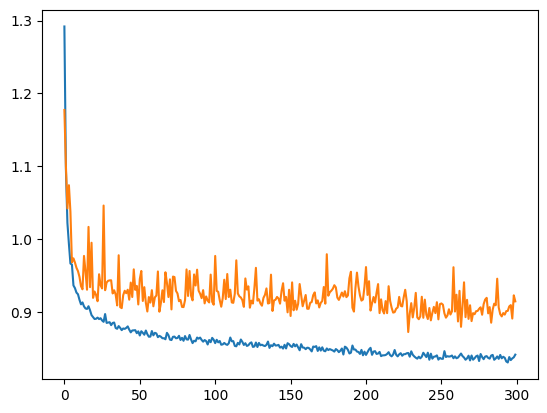

In [10]:
plt.plot(losses)
plt.plot(val_losses)

In [74]:
# test model accuracy
model = torch.load('simmodel.pth')
model.eval()
test_outputs = model(torch.tensor(latent_data).to(device))


In [75]:
test_outputs_categorical = np.zeros(test_outputs.shape)
for i in range(len(test_outputs)):
    _, indices = torch.max(test_outputs[i], 0)    
    predicted_label = indices.item()
    test_outputs_categorical[i][predicted_label] = 1

Text(0.5, 1.0, 'Confusion Matrix')

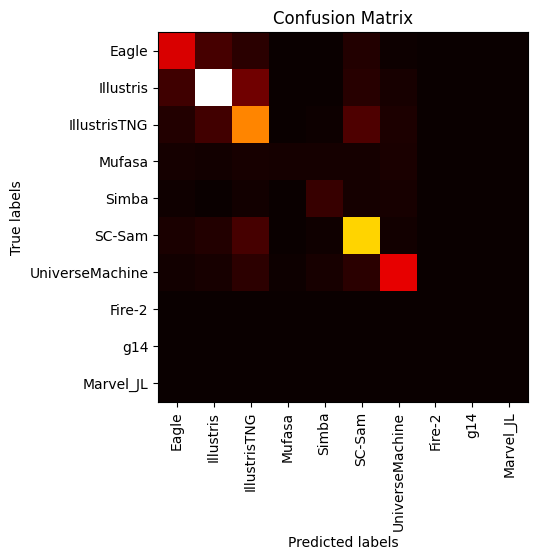

In [109]:
confusion_matrix = np.zeros((10, 10))
for i in range(len(labels_vectors)):
    true_label = np.argmax(labels_vectors[i])
    predicted_label = np.argmax(test_outputs_categorical[i])
    confusion_matrix[true_label][predicted_label] += 1

plt.imshow(confusion_matrix, cmap='hot', interpolation='nearest')
# Labelling the simulation names

sim_names = ['Eagle', 'Illustris', 'IllustrisTNG', 'Mufasa', 'Simba', 'SC-Sam', 'UniverseMachine', 'Fire-2', 'g14', 'Marvel_JL']
plt.xticks(np.arange(10), sim_names, rotation=90)
plt.yticks(np.arange(10), sim_names)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

In [102]:
# Printing the confusion matrix without scientific notation
np.set_printoptions(suppress=True)
print(confusion_matrix)

[[ 4617.  1358.   732.    34.    41.   551.   112.     0.     0.     0.]
 [ 1160. 14837.  2312.    44.    14.   663.   324.     0.     0.     0.]
 [  522.  1260.  8354.    26.    65.  1563.   430.     0.     0.     0.]
 [  238.   207.   316.   249.   245.   245.   400.     0.     0.     0.]
 [  133.    32.   193.    33.  1039.   237.   315.     0.     0.     0.]
 [  384.   565.  1343.    30.   141. 10135.   223.     0.     0.     0.]
 [  212.   345.   800.    69.   293.   732.  4910.     0.     0.     0.]
 [    0.     9.     2.     0.     0.     2.     1.     0.     0.     0.]
 [    2.     3.     0.     0.     0.     3.     0.     0.     0.     0.]
 [    1.     3.     1.     0.     0.     0.     0.     0.     0.     0.]]


In [12]:
# Saving the model
torch.save(model, 'simmodel.pth')